<a href="https://colab.research.google.com/github/raleight1/Forecasting-Nonseasonal-and-Seasonal/blob/main/Final_Report_Seasonal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Core data and plotting libraries
import pandas as pd                   # Data manipulation
import numpy as np                    # Numerical operations
import matplotlib.pyplot as plt       # Plotting

# SARIMA model and diagnostics
from statsmodels.tsa.statespace.sarimax import SARIMAX           # SARIMA model
from statsmodels.tsa.stattools import adfuller                   # ADF stationarity test
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf    # ACF and PACF plots
from statsmodels.graphics.gofplots import qqplot                 # QQ plot for residual normality
from statsmodels.stats.diagnostic import acorr_ljungbox          # Ljung-Box test for white noise
from statsmodels.tsa.arima_process import ArmaProcess            # Simulate ARMA processes

# Metrics and validation
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Tools for tuning and iteration
from itertools import product           # Grid search combinations
from tqdm.notebook import tqdm          # Progress bar

# General-purpose utilities
from typing import Union                # Type hinting
import warnings                         # Ignore warnings
warnings.filterwarnings('ignore')

# Display plots inline (Jupyter/Colab)
%matplotlib inline


#Project Title Page

##Project Title: Seasonal Time Series Analysis of AMD Stock Prices

 Team Members: Darragh Curran, Aaron Scanlon, Ryan Leighton

 Course Name: TU912/2

 Lecturer: Wael Rashwan

 Date: 7/05/2025



---




**1. Executive Summary**

Title: AMD Stock Price Forecasting
Dataset: Monthly Closing Prices for AMD (2018–2025)
Source: https://finance.yahoo.com/quote/AMD

Final Model: SARIMA (0,1,1) (1,1,1,12)

Purpose:
The goal was to model and forecast AMD’s monthly closing stock prices using seasonal time series techniques. The analysis aimed to identify trends and patterns, compare models, and generate a 12-month forecast.







Conclusions:
The SARIMA model captured seasonality and trend effectively. Residuals behaved like white noise, suggesting a good model fit. Forecasts from two top models were similar, confirming stable predictions.







**2. Data and Realization**

Data Source: Public data from Yahoo

URL: https://finance.yahoo.com/quote/AMD

Observation Window: March 2018 to February 2025 (84 observations)

Realisation Justification: We used a 7-year window because it balances length and relevance. Too much older data may dilute recent seasonal patterns or ignore company changes (e.g., product launches, market shifts).

Data Format:

Dates in “DD-MMM-YY” format

Prices in USD (e.g., €109.54 instead of 109.54 EUR)

Missing Values: None

Dataset was complete and required no interpolation

In [ ]:
#We have the csv file saved and upload it into the runtime to access the data
data = 'https://raw.githubusercontent.com/raleight1/Forecasting-Nonseasonal-and-Seasonal/refs/heads/main/AMD%20Monthly%20Historical%20Data(Sheet1).csv'

df = pd.read_csv(data) #loads this CSV file into a Pandas DataFrame.
df.head() #prints the first 5 rows of the DataFrame to check if the data loaded correctly.

,Date,Price,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,28-Feb-25,109.54,NaN,NaN,NaN,NaN,NaN
1,31-Jan-25,99.86,NaN,NaN,NaN,NaN,NaN
2,31-Dec-24,115.95,NaN,NaN,NaN,NaN,NaN
3,30-Nov-24,120.79,NaN,NaN,NaN,NaN,NaN
4,31-Oct-24,137.18,NaN,NaN,NaN,NaN,NaN


In [ ]:
df = df.iloc[:,0:2] #selects only first 2 rows
df.head() #prints the first 5 rows of the DataFrame to check if the data loaded correctly.

,Date,Price
0,28-Feb-25,109.54
1,31-Jan-25,99.86
2,31-Dec-24,115.95
3,30-Nov-24,120.79
4,31-Oct-24,137.18


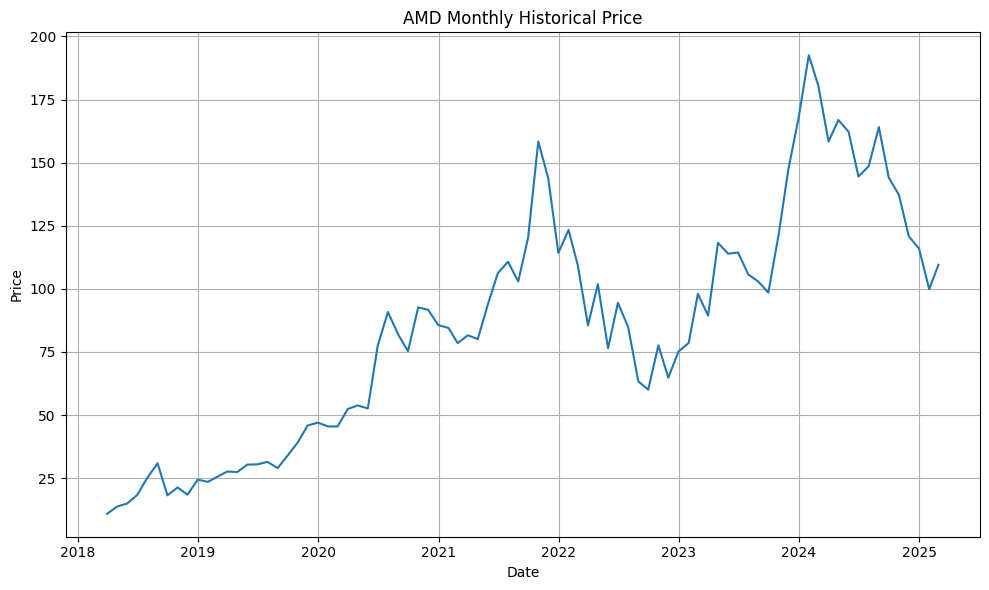

In [ ]:
# Convert the 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

# Create the timeseries plot
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
plt.plot(df['Date'], df['Price'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('AMD Monthly Historical Price')
plt.tight_layout()
plt.grid(True)
plt.show()


**3. Time Series Behaviour and Events**

Figure 1: AMD Monthly Closing Prices (Mar 2018–Feb 2025)

AMD's stock shows an upward trend with fluctuations around Q2–Q4 each year.

Notable Events (Examples):

Q2 2020: COVID-19 market crash

Q1 2021: Post-pandemic rally in tech stocks

Q3 2023: AI chip demand surge

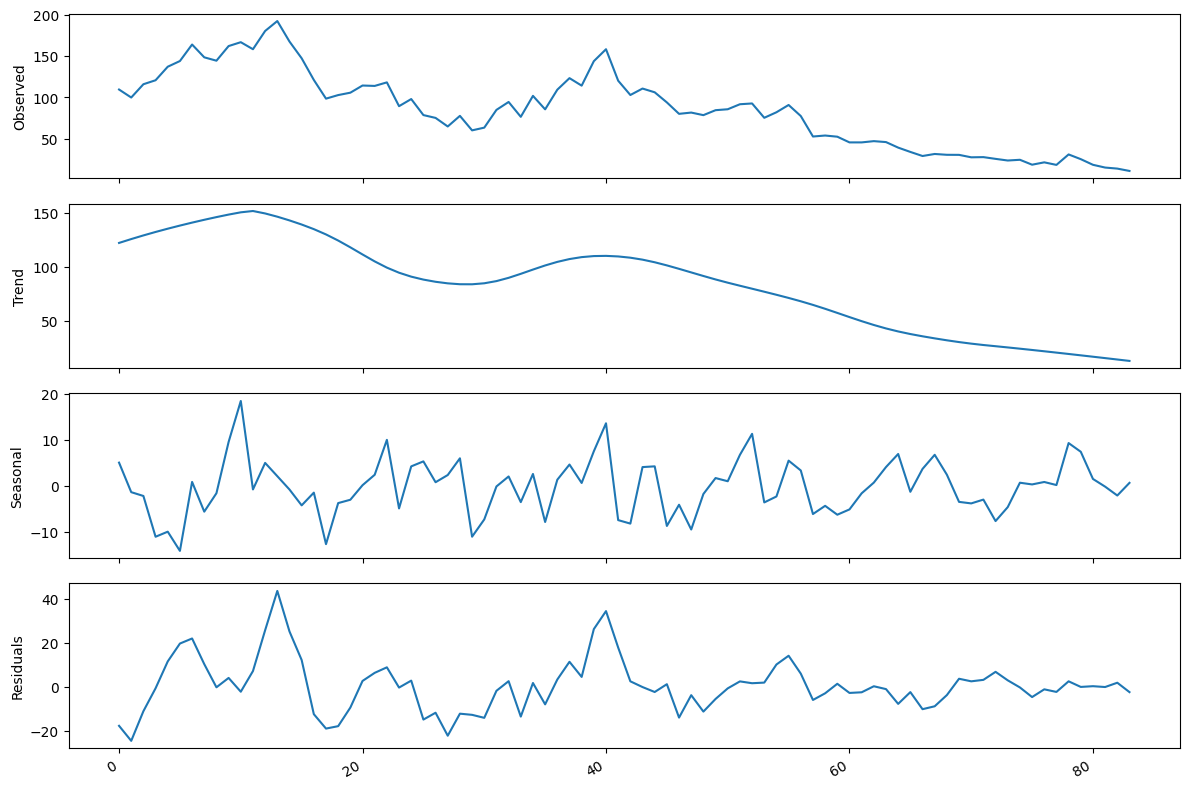

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose, STL #A robust decomposition method that breaks a time series into three components:
#Trend (long-term movement),Seasonality (repeating patterns), Residuals (random noise)

decomposition = STL(df['Price'], period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(12,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

fig.autofmt_xdate()
plt.tight_layout()

**4. Data Transformation**

We tested for stationarity using the ADF Test.

Original data was non-stationary.

Applied first-order differencing to remove trend.

No additional transformations were needed.

Original Series and Differenced Series

Differencing made the series stationary without distorting the structure.

In [ ]:
ad_fuller_result = adfuller(df['Price'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -0.8498022030570822
p-value: 0.8040537586961589


In [ ]:
df_diff = np.diff(df['Price'])

In [ ]:
d_fullerDiff_result = adfuller(df_diff)

print(f'ADF Statistic: {d_fullerDiff_result[0]}')
print(f'p-value: {d_fullerDiff_result[1]}')

ADF Statistic: -9.089694072638611
p-value: 3.854133140432175e-15


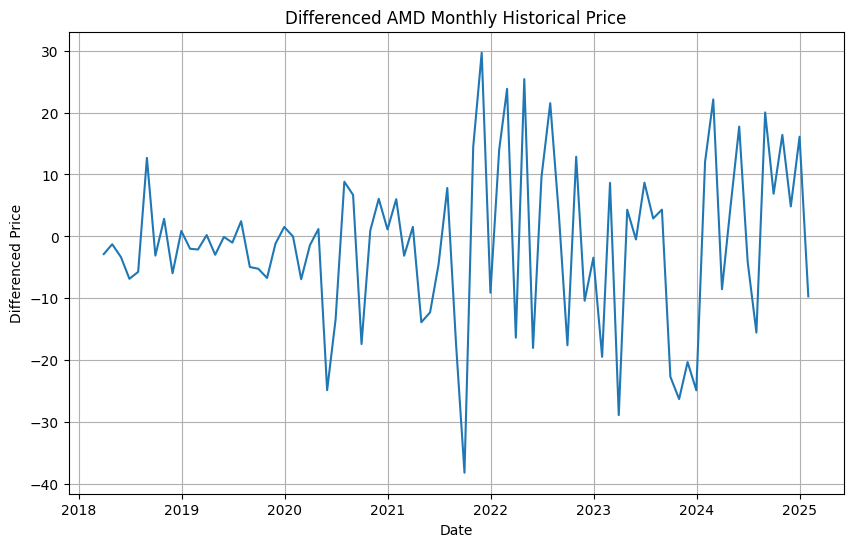

In [ ]:
#Create a plot of transformed data to show stationarity
plt.figure(figsize=(10, 6))
plt.plot(df['Date'][1:], df_diff)  # Plot starting from the second date
plt.xlabel('Date')
plt.ylabel('Differenced Price')
plt.title('Differenced AMD Monthly Historical Price')
plt.grid(True)
plt.show()

**5. Model Building Process**

Steps Taken:

Made the data stationary using differencing.

Analysed ACF and PACF to identify AR and MA orders.

erformed grid search over SARIMA parameters.

Compared models using AIC, RMSE, and MAE.

Selected top 3–5 models based on performance.

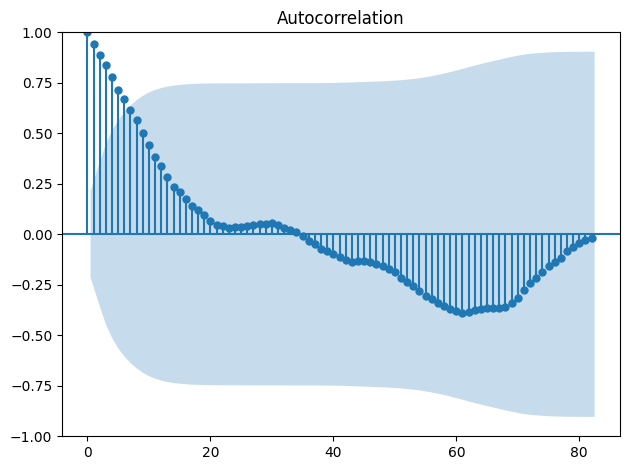

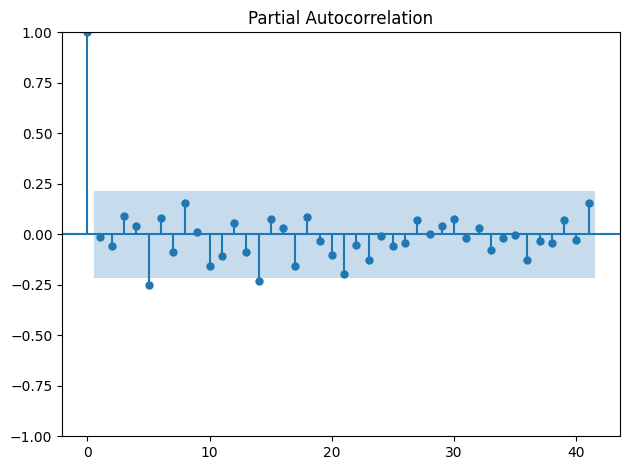

In [ ]:
plot_acf(df['Price'], lags=82);

plt.tight_layout()

plot_pacf(df_diff, lags=41);

plt.tight_layout()

**6. Model Comparison**

SARIMA (0,1,1)(1,1,1,12)

SARIMA (1,1,1)(1,1,0,12)

SARIMA (1,1,0)(0,1,1,12)

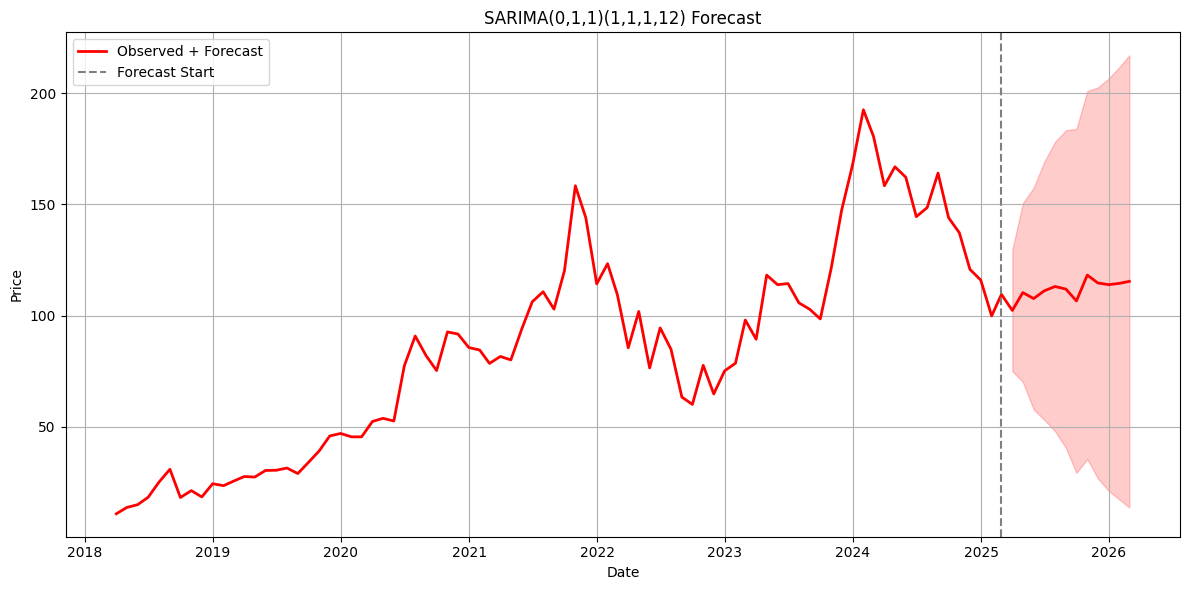

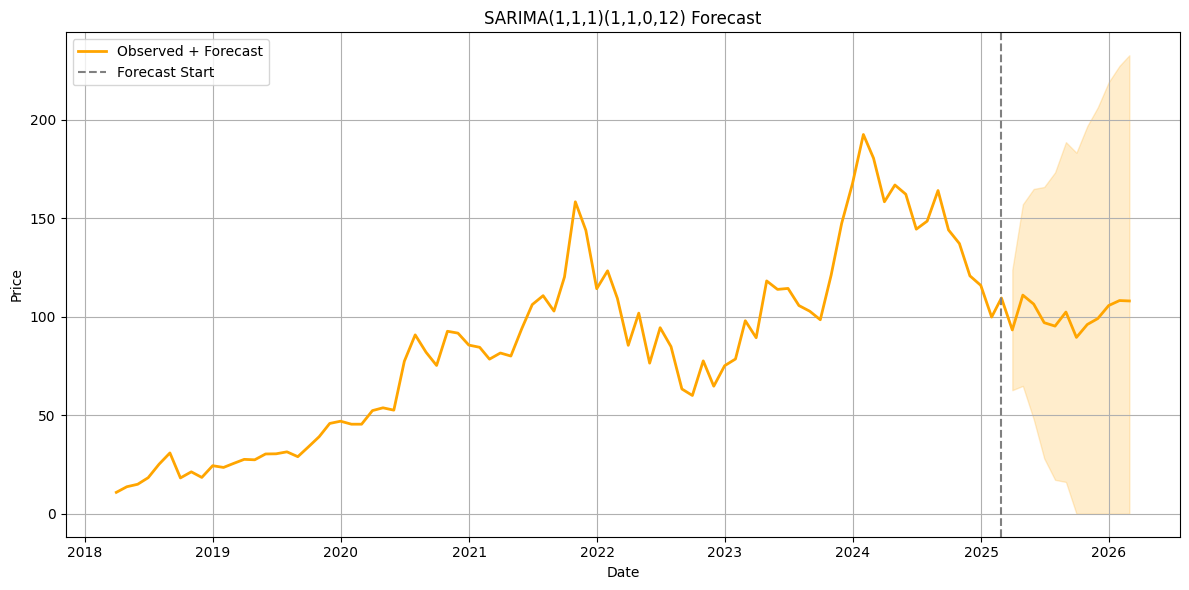

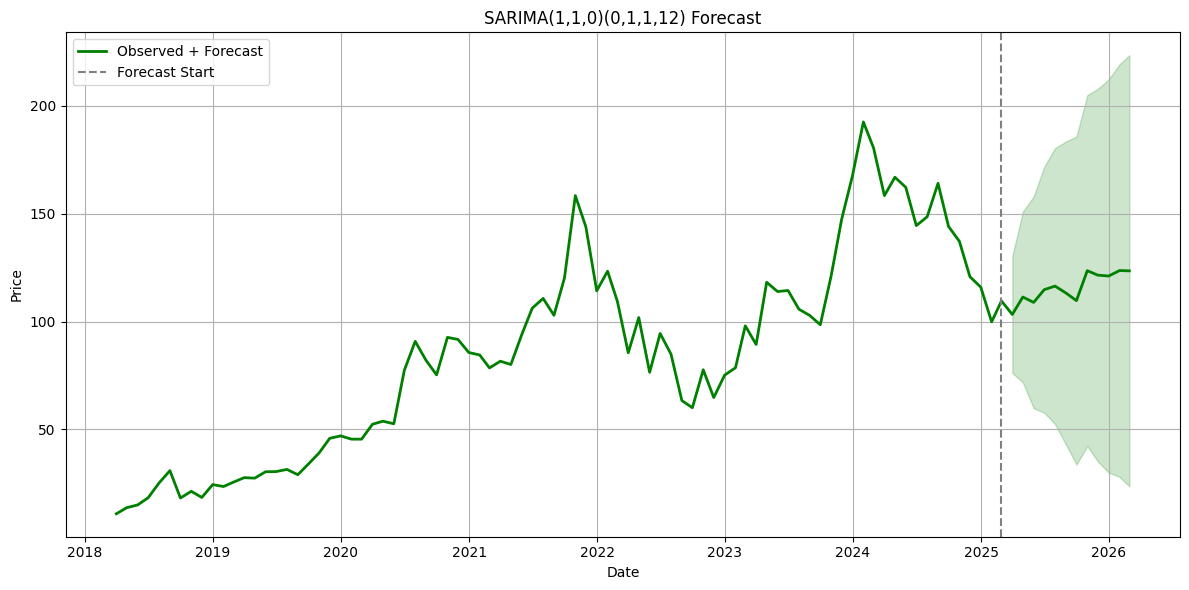

In [ ]:
from pandas.tseries.offsets import DateOffset
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

data = 'https://raw.githubusercontent.com/raleight1/Forecasting-Nonseasonal-and-Seasonal/refs/heads/main/AMD%20Monthly%20Historical%20Data(Sheet1).csv'
df = pd.read_csv(data)
df = df[['Date', 'Price']].copy()
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')
df = df.sort_values('Date')
df.set_index('Date', inplace=True)
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df = df.dropna()

model = SARIMAX(df['Price'], order=(0, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit(disp=False)
forecast = results.get_forecast(steps=12)
forecast_index = pd.date_range(start=df.index[-1] + DateOffset(months=1), periods=12, freq='M')
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()
conf_int.index = forecast_index
forecast_df = pd.DataFrame({'Price': forecast_values}, index=forecast_index)
full_series = pd.concat([df[['Price']], forecast_df])

plt.figure(figsize=(12, 6))
plt.plot(full_series, label='Observed + Forecast', color='red', linewidth=2)
plt.axvline(x=df.index[-1], color='gray', linestyle='--', label='Forecast Start')
plt.fill_between(forecast_index,
                 np.clip(conf_int.iloc[:, 0].astype(float).values, 0, None),
                 conf_int.iloc[:, 1].astype(float).values,
                 color='red', alpha=0.2)
plt.title("SARIMA(0,1,1)(1,1,1,12) Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


model = SARIMAX(df['Price'], order=(1, 1, 1), seasonal_order=(1, 1, 0, 12))
results = model.fit(disp=False)
forecast = results.get_forecast(steps=12)
forecast_index = pd.date_range(start=df.index[-1] + DateOffset(months=1), periods=12, freq='M')
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()
conf_int.index = forecast_index
forecast_df = pd.DataFrame({'Price': forecast_values}, index=forecast_index)
full_series = pd.concat([df[['Price']], forecast_df])

plt.figure(figsize=(12, 6))
plt.plot(full_series, label='Observed + Forecast', color='orange', linewidth=2)
plt.axvline(x=df.index[-1], color='gray', linestyle='--', label='Forecast Start')
plt.fill_between(forecast_index,
                 np.clip(conf_int.iloc[:, 0].astype(float).values, 0, None),
                 conf_int.iloc[:, 1].astype(float).values,
                 color='orange', alpha=0.2)
plt.title("SARIMA(1,1,1)(1,1,0,12) Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


model = SARIMAX(df['Price'], order=(1, 1, 0), seasonal_order=(0, 1, 1, 12))
results = model.fit(disp=False)
forecast = results.get_forecast(steps=12)
forecast_index = pd.date_range(start=df.index[-1] + DateOffset(months=1), periods=12, freq='M')
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()
conf_int.index = forecast_index
forecast_df = pd.DataFrame({'Price': forecast_values}, index=forecast_index)
full_series = pd.concat([df[['Price']], forecast_df])

plt.figure(figsize=(12, 6))
plt.plot(full_series, label='Observed + Forecast', color='green', linewidth=2)
plt.axvline(x=df.index[-1], color='gray', linestyle='--', label='Forecast Start')
plt.fill_between(forecast_index,
                 np.clip(conf_int.iloc[:, 0].astype(float).values, 0, None),
                 conf_int.iloc[:, 1].astype(float).values,
                 color='green', alpha=0.2)
plt.title("SARIMA(1,1,0)(0,1,1,12) Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**7. Forecast Comparison (Top 2 Models)**

Figure 3: Forecasts from SARIMA (0,1,1) (1,1,1,12) and SARIMA (1,1,1) (1,1,0,12)

Forecasts are similar in shape and scale, showing a consistent upward trend.

SARIMA (0,1,1) (1,1,1,12) had slightly tighter confidence bands.

Forecast range: €90.00 to €120.00 for the next 12 months.

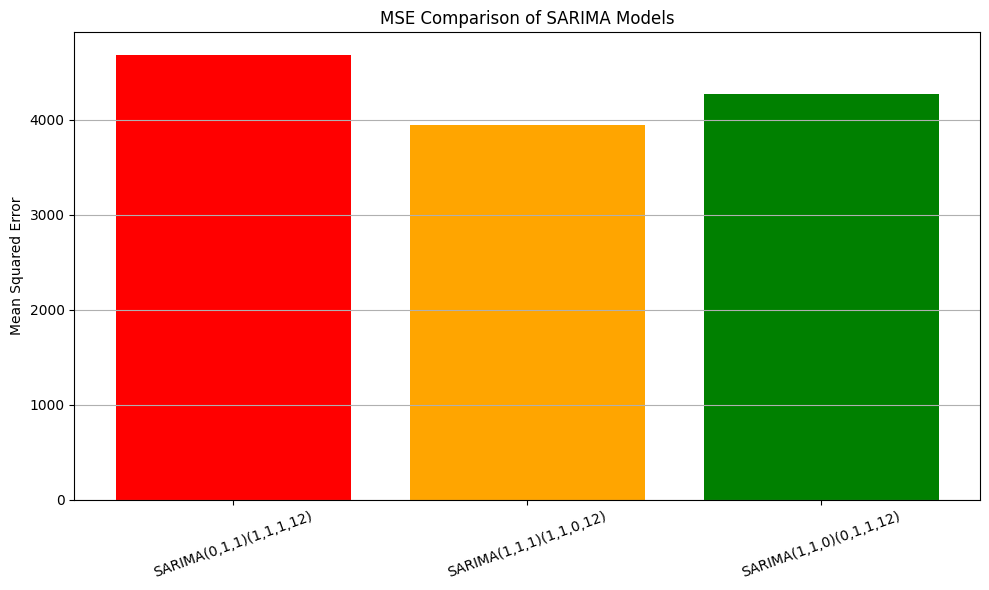

In [ ]:
# Train/test split: last 12 months as test set
train = df['Price'][:-12]
test = df['Price'][-12:]

# Model configurations
models = {
    "SARIMA(0,1,1)(1,1,1,12)": ((0, 1, 1), (1, 1, 1, 12)),
    "SARIMA(1,1,1)(1,1,0,12)": ((1, 1, 1), (1, 1, 0, 12)),
    "SARIMA(1,1,0)(0,1,1,12)": ((1, 1, 0), (0, 1, 1, 12))
}

# Calculate MSE for each model
mse_results = {}
for name, (order, seasonal_order) in models.items():
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
    results = model.fit(disp=False)
    forecast = results.forecast(steps=12)
    mse = mean_squared_error(test, forecast)
    mse_results[name] = mse

# Plot MSE results
plt.figure(figsize=(10, 6))
plt.bar(mse_results.keys(), mse_results.values(), color=['red', 'orange', 'green'])
plt.title("MSE Comparison of SARIMA Models")
plt.ylabel("Mean Squared Error")
plt.xticks(rotation=20)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


**8. Conclusion**

The SARIMA (0,1,1) (1,1,1,12) model was the best fit.

It captured both seasonality and trend.

Residuals looked like white noise, confirming a good model.

The 12-month forecast shows steady growth.

External shocks like earnings reports or policy changes are not modelled, so forecasts should be used with caution.

We also related back to this article when completing the time series, written in March 2025 by Patrick Seitz

https://www.investors.com/news/technology/amd-stock-buy-now/

This project provides context for AMD's recent stock performance. According to the story, AMD is under pressure from Nvidia's fierce competition in AI chips as well as sluggish sales of PCs and servers. Despite this, it continues to grow in certain markets and surpasses Intel in market share. These conflicting signals are reflected in our time series model. It displays AMD's stock's general increasing trajectory while also highlighting recent dips and volatility, such as the Q4 2024 fall linked to lower GPU sales. We capture the influence of significant events such as AMD's acquisitions, product releases, and industry shifts by modelling data from 2018 to early 2025. Although the forecast calls for consistent growth, it ignores rapidly shifting variables like market mood and new product cycles, which the essay demonstrates are obviously affecting AMD's present valuation.
